In [1]:
from IPython.display import YouTubeVideo, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Results: Whole Brain (316 ROIs)

## Search Grid With 5-fold Cross Validation

In order to make the model generalizable and avoid overfitting, hyperparameters like: 1)  `L2` regularization, 2) `dropout`, and 3) `learning_rate` were optimized using a k-fold nested cross-validation method. Seventy-five different combinations of the aforementioned hyperparameters were used to train and validate the model. Figure below shows the training and validation set performance of the 75 models. The models are arranged in the descending order of their mean validation accuracy. The error bars indicate standard deviation across folds. As the number of classes in the dataset were balanced, accuray was an appropriate metric to evaluate the model performance.

In [16]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk",style='whitegrid')
import pandas as pd
import numpy as np
np.random.seed(42)
import tensorflow as tf

import os
from joblib import dump, load

from src.preprocess.dataset import *
from src.models.model_selection import classifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import plotly
import plotly.graph_objs as go

%matplotlib inline

In [3]:
with open("../../results/00-ROI316_last_segment/grid_search.pkl","rb") as file:
    results, param_grid = pickle.load(file)

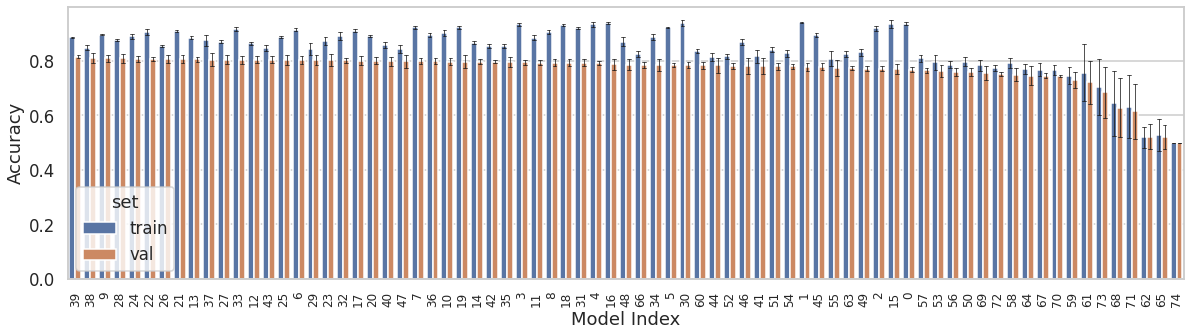

In [4]:
table = pd.DataFrame.from_dict({(i,j,k): results[i][j][k] for i in results.keys() for j in results[i].keys() for k in results[i][j].keys()}).T
table.reset_index(inplace=True)
table.rename(columns={'level_0':'model','level_1':'fold','level_2':'set',0:'acc'},inplace=True)

table['mod_num'] = table.model.str[5:].astype(int)
order = table[table['set']=='val'].groupby('mod_num')['acc'].mean().sort_values(ascending = False).index
plt.figure(figsize=(20,5))
sns.barplot(x='mod_num',y='acc',hue='set',ci='sd',data=table,
            palette=['C0','C1'],order=order,errwidth=0.75,
            errcolor='k',capsize=0.25)
plt.xticks(rotation=90,fontsize=12)
plt.xlabel('Model Index')
_=plt.ylabel('Accuracy')

Best performing model yielded mean __training__ and __validation__ accuracies of __0.89__ and __0.82__, respectively. Its hyperparameters were: 1) `L2 = 0.003`, `dropout = 0.3`, and `learning_rate = 0.001`.

In [5]:
# load data
dataset = Dataset('../../data/processed/00a-ROI316_withShiftedSegments.pkl')
dataset.load()
dataset_df = organize_dataset(selective_segments(dataset.data,5))
dataset.train_test_split_sid()

In [6]:
# Split the data into train and test sets
X_train, y_train = query_dataset(dataset_df,dataset.train_idx)
X_test, y_test = query_dataset(dataset_df,dataset.test_idx)

# load the trained model
model = tf.keras.models.load_model('../../models/00-ROI316_last_segment/CustomGRU.h5')

In [7]:
# Evalute the trained model on each participant from the training set individually
from collections import defaultdict
from sklearn.metrics import accuracy_score

test_acc = defaultdict(dict)
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    X_test, y_test = query_dataset(dataset_df,[subj_idx])
    y_pred = np.squeeze(model.predict_classes(X_test))
    for tp in range(X_test.shape[1]):
        test_acc[subj]['TP{:02d}'.format(tp)] = accuracy_score(y_test,y_pred[:,tp])
    loss, acc = model.evaluate(X_test,y_test)
    test_acc[subj]['overall'] = acc

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
3/3 [==============================] - 0s 5ms/step - loss: 0.6722 - acc: 0.7407


In [8]:
test_acc_df = pd.DataFrame(columns=['Subj','TP','Accuracy'])
for SUB in test_acc:
    for TP in test_acc[SUB]:
        temp_df = pd.DataFrame([SUB, TP, test_acc[SUB][TP]], index=['Subj','TP','Accuracy']).T
        test_acc_df = pd.concat([test_acc_df,temp_df],axis=0,ignore_index=True)
        
test_acc_df['Accuracy'] = test_acc_df['Accuracy'].astype(float)

## Test Data Performance
### Accuracy

The trained model was tested on the near-miss segments of the 19 held-out participants. Following figure shows temporal and overall accuracies on the held-out participants. The model performs resonably well from the 1st timepoint (TP) itself, with a mean accuracy of __0.8__. The mean accuracy steadily increases to __0.89__ by the 7th TP. "Overall" accuracy is the mean accuracy across TP, which is __0.83__.  

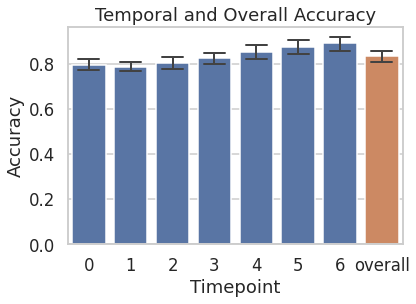

In [31]:
sns.barplot(x='TP',y='Accuracy',data=test_acc_df,ci=95,palette=['C0']*7+['C1'],errwidth=2,capsize=0.5)
plt.xticks(ticks=np.arange(8),labels=list(range(7))+['overall'])
plt.xlabel('Timepoint')
_=plt.title('Temporal and Overall Accuracy')

### Probability of predicting the true class as a function of time

Following figure shows probability of predicting the true class as a function of time. The probability of predicting the true class increases with time.

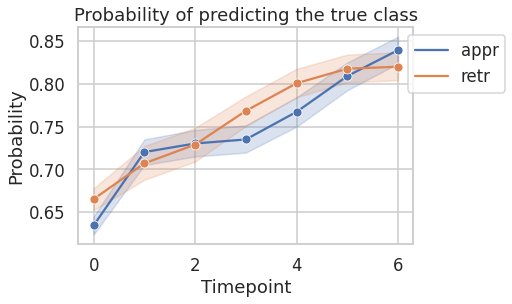

In [30]:
## get probabilities of the true class at every timepoint
prob_df = pd.DataFrame(columns=['Subj','TP','class','prob'])
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    for direction, k_class in zip(['appr','retr'],[1.,0.]):
        X_test, y_test = query_dataset(dataset_df,[subj_idx])
        X_test, y_test = X_test[y_test==k_class], y_test[y_test==k_class]
        if k_class == 1.:
            temp_df = pd.DataFrame(np.squeeze(model.predict(X_test)))
        else:
            temp_df = pd.DataFrame(1-np.squeeze(model.predict(X_test)))
        temp_df['Subj'] = subj
        temp_df['class'] = direction
        temp_df = temp_df.melt(id_vars=['Subj','class'],var_name='TP',value_name='prob')
        prob_df = pd.concat([prob_df,temp_df],axis=0, ignore_index=True)
        
sns.lineplot(x='TP',y='prob',hue='class',data=prob_df,
             ci=95, markers=True,marker='o',dashes=False,
             hue_order=['appr','retr'],palette=['C0','C1'])
plt.xlabel('Timepoint')
plt.legend(loc='upper right',bbox_to_anchor=(1.3,1))
plt.ylabel('Probability')
_=plt.title('Probability of predicting the true class')

## Chance Accuracy

To assess significance of the observed test accuracy of 0.83, the observed test accuracy was compared against chance accuracy. Chance accuracy is obtained when the model predicts one of the two classes at random. To simulate a chance accuray distribution, the model with best hyperparameter settings was trained on the training data a hundred times, each time with shuffled labels. At every iteration, the model was tested on the test data with non-shuffled (i.e., true) labels, and the accuracy was recorded. From the chance accuracy distribution, it was found that the chance of achieving an accuracy of at least 0.83 was less than 0.009. See the figure below.

In [11]:
with open('../../results/00-ROI316_last_segment/perm_acc.pkl',"rb") as f:
    obs_acc, results_perm = pickle.load(f)

Accuracy
Observed: 0.83
Chance: 0.50
Observed > Chance (p = 0.0099)


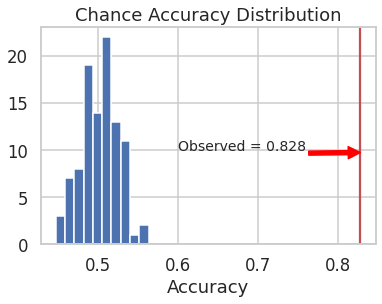

In [12]:
plt.hist(results_perm['val'],bins=int(np.sqrt(len(results_perm['val']))))
plt.axvline(obs_acc['obs_test_acc'],c='r',label=None)
plt.xlabel('Accuracy')
plt.title('Chance Accuracy Distribution')
_=plt.annotate('Observed = %.3f' %(obs_acc['obs_test_acc']),
               xy=(obs_acc['obs_test_acc'],9.75),
               xytext=(0.6,10),
               arrowprops={'color':'red'},
               fontsize=14)
p_val = (np.sum(np.array(results_perm['val']) > obs_acc['obs_test_acc'])+1)/(len(results_perm['val'])+1)
print('Accuracy')
print('Observed: %.2f'%obs_acc['obs_test_acc'])
print('Chance: %.2f'%np.mean(results_perm['val']))
print('Observed > Chance (p = %.4f)' %(p_val))

## Comparision with Random Forest

As GRU belongs to the family of recurrent neural networks, it learns class separability from the sequential aspect of the data. Since the data used in this project is fMRI time-series data, GRU was a reasonable model choice. An interesting question that can be asked is, how well would a model that does not take into account the sequential aspect of the data perform? Would it perform as well as the GRU model? Or would it perform poorly? To make this comparison, a Random Forest classifier was trained on the current data. The Random Forest classifier was also fine tuned using the nested cross validation method, and best hyperparameters (n_estimators = 1500, max_feature = ‘sqrt’) were obtained. The test accuracy of Random Forest classifier was only 0.58 which is significantly low compared to that of the GRU model.

In [17]:
n_features = 316
features = ['feat%i'%i for i in range(1,n_features+1)]

# all participant IDs
participants = dataset_df.participant.unique()

'''
Reorganizing the data in the form of datafame to be compatible with 
the format accepted by sklearn models
'''
df = pd.DataFrame()
for ii, row in dataset_df.iterrows():
    tmp_df = pd.DataFrame(row["data"], columns = features)
    tmp_df['subject'] = row["participant"]
    tmp_df['timepoint'] = np.arange(7)+1
    tmp_df['y'] = row["label"]
    df = pd.concat([df,tmp_df],ignore_index=True)

In [19]:
def train_test_split(df):
    '''
    Splits the dataframe into train and test sets
    
    X_train, X_test, y_train, y_test = train_test_split(df)
    '''
    train = df[df['subject'].isin(participants[dataset.train_idx])]
    test = df[df['subject'].isin(participants[dataset.test_idx])]
    return train[features], test[features], train['y'], test['y']

# Split data into train (42 participants) and test (19 participants) 
X_train, X_test, y_train, y_test = train_test_split(df)

# Cross-validate Random forest classifier
rfc_path = '../../models/00-ROI316_last_segment/rf_classifier.joblib'
if os.path.exists(rfc_path):
    rfc = load(rfc_path)
else:
    rfc = RandomForestClassifier(1500,max_features="sqrt")
    # Re-train and test the classifier
    rfc.fit(X_train,y_train)

print('Random forest test accuracy: %.2f'%rfc.score(X_test,y_test))

Random forest test accuracy: 0.58


## Temporal Trajectories

GRU outputs hidden states that are typically high dimensional. Hidden states ($h_{t}$) capture spatio-temporal variance that is most useful in maintaning class separability. To visualize dynamics, $h_{t}$ was linearly projected onto a lower (3D) dimensional space, $\hat{h_{t}}$. This was done by replacing the output layer with a _Dimensionality Reduction Dense Layer (DRDL)_ with three linear units. In essence, this is a supervised non-linear dimensional reduction step. 



<img src="../../support/images/DRDL.png" alt="Dimensionality Reduction Dense Layer" width="300"/>



The 3-dimensional representations of $h_{t}$ ($\hat{h_{t}}$) for both stimulus class are plotted along the three axes of the coordinate system below. The plot represents the temporal trajectories of the two classes. At the first timepoint the two classes are closest to each other. Distance between them increases with every timepoint. Next plot shows the Euclidean distance between the two classes as a function of time.

In [21]:
# Make a copy the model
# (tips: https://stackoverflow.com/questions/57316557/tf-keras-layers-pop-doesnt-work-but-tf-keras-layers-pop-does)
#tf.random.set_seed(50)
tf.random.set_seed(47)
BestModel = tf.keras.models.clone_model(model)
BestModel.set_weights(model.get_weights())

# Replace the the last Time-Distributed layer with Fully connected layer with only two units
BestModel = tf.keras.Sequential(BestModel.layers[:-1])

# add a new time-distributes dense layer with 2 units and 'linear' activation function
BestModel.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3,activation='linear')))

# Set trainable = False for the layers from BestModel
for layers in BestModel.layers:
    layers.trainable = False

BestModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 16)          16032     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
gru_2 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           51        
Total params: 19,347
Trainable params: 0
Non-trainable params: 19,347
_________________________________________________________________


In [22]:
trajectory = {}
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    X_test, y_test = query_dataset(dataset_df,[subj_idx])
    y_pred = BestModel.predict(X_test)
    appr = y_pred[y_test==1.,:,:].mean(axis=0)
    retr = y_pred[y_test==0.,:,:].mean(axis=0)
    trajectory[subj] = {'Approach':{'x1':list(appr[:,0]),'x2':list(appr[:,1]),'x3':list(appr[:,2])},
                        'Retreat':{'x1':list(retr[:,0]),'x2':list(retr[:,1]),'x3':list(retr[:,2])}}

In [23]:
trajectory_df = pd.DataFrame.from_dict({(i,j,k): trajectory[i][j][k] 
                                        for i in trajectory.keys() 
                                        for j in trajectory[i].keys() 
                                        for k in trajectory[i][j].keys()}).T
trajectory_df = trajectory_df.stack().unstack(2).stack()
trajectory_df = trajectory_df.to_frame(name='trajectory')
trajectory_df.reset_index(inplace=True)
trajectory_df.rename(columns={'level_0':'Subj','level_1':'Direction','level_2':'TP','level_3':'axis'},inplace=True)
trajectory_df = trajectory_df.groupby(['Direction','TP','axis'])['trajectory'].mean().unstack(-1).reset_index()

In [24]:
approach_x1 = trajectory_df[trajectory_df['Direction']=='Approach']['x1']
approach_x2 = trajectory_df[trajectory_df['Direction']=='Approach']['x2']
approach_x3 = trajectory_df[trajectory_df['Direction']=='Approach']['x3']

retreat_x1 = trajectory_df[trajectory_df['Direction']=='Retreat']['x1']
retreat_x2 = trajectory_df[trajectory_df['Direction']=='Retreat']['x2']
retreat_x3 = trajectory_df[trajectory_df['Direction']=='Retreat']['x3']

In [25]:
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure trace for approach.
appr = go.Scatter3d(
    x=approach_x1,  # <-- Put your data instead
    y=approach_x2,  # <-- Put your data instead
    z=approach_x3,  # <-- Put your data instead
    mode='lines+markers',
    marker={
        'size': 8,
        'opacity': 0.8,
        'color':'red'
    },
    name='Approach'
)

retr = go.Scatter3d(
    x=retreat_x1,  # <-- Put your data instead
    y=retreat_x2,  # <-- Put your data instead
    z=retreat_x3,  # <-- Put your data instead
    mode='lines+markers',
    marker={
        'size': 8,
        'opacity': 0.8,
        'color':'green'
    },
    name='Retreat'
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [appr,retr]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
#plotly.offline.iplot(plot_figure)
# (tip: https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook)
plotly.offline.plot(plot_figure, filename = 'figures/trajectories.html', config = None)
display(HTML('figures/trajectories.html'))

In [26]:
# Calculate Euclidean distance between approach and retreat trajectories.
approach_dim3 = np.stack([approach_x1,approach_x2,approach_x3],axis=1)
retreat_dim3 = np.stack([retreat_x1,retreat_x2,retreat_x3],axis=1)
traj_dim3 = np.stack([approach_dim3,retreat_dim3])

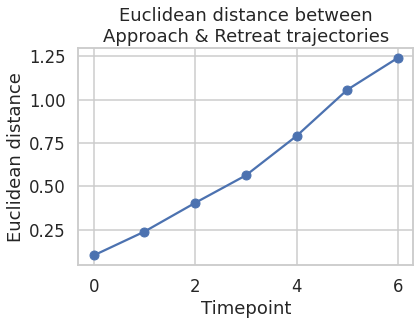

In [27]:
plt.plot(np.squeeze(np.linalg.norm(np.diff(traj_dim3,axis=0),
                                     axis=2)),marker='o')
plt.xlabel('Timepoint')
plt.ylabel('Euclidean distance')
_=plt.title('Euclidean distance between\nApproach & Retreat trajectories')

## Conclusion 
The above trajectories and Euclidean distance plots suggest that the GRU architecture is able to characterize distinct spatio-temporal patterns in the fMRI data, for appraoching and retreating threats.

## Demonstration

The following video clip demonstrates model performance on one of the held out participant's fMRI data. The video shows the visual paradigm presented to the participant during his/her fMRI scan, along with model predictions at the top-right of the screen. Prediction is either "Approach" or "Retreat". If the prediction is correct, the color of the text remains green; and if it is incorrect, it turns red. Note that when the circles touch, the screen turns white and a red wheel appears around the circles to indicate delivery of the physical shock. Also note that the speed of the video has been increased by 4x for quick demonstration purposes.

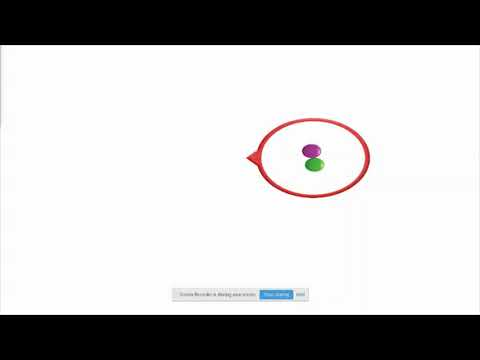

In [28]:
YouTubeVideo('t7kMuK62k8Y', width=800, height=500)